In [1]:
#Authors: Eli Gumble, Peter Brommer, Harry Brown
#Initialisation
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
from scipy import signal as sg
from scipy.interpolate import RectBivariateSpline as ReBiSpline 
from numpy import ma
from matplotlib import colors, ticker, cm
from random import choice

import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

import timeit

from PIL import Image
%matplotlib inline

In [2]:
# Read grids from image
im = Image.open("cc_fin.bmp")
Base = np.array(im)

In [3]:
scale = 0.25 #m per pixel
Nx = Base[:,0,0].size #N appears to be resolution
Ny = Base[0,:,0].size
xmin=-scale*0.5*(Nx-1)
xmax=scale*0.5*(Nx-1)
ymin=-scale*0.5*(Ny-1)
ymax=scale*0.5*(Ny-1)
x = np.linspace(xmin, xmax, Nx) # This is defining the axes and full space
y = np.linspace(ymin, ymax, Ny)
Y, X= np.meshgrid(y, x)
TrailPotential = np.zeros((Nx,Ny))
DestinationPotential=np.zeros((Nx,Ny))
Weight=np.zeros((Nx,Ny))
intens=np.zeros((Nx,Ny))
q_alpha=np.zeros((Nx,Ny))
expdist=np.zeros((2*Nx-1,2*Ny-1))
dest=np.zeros((2))
start=np.zeros((2))
grad=np.zeros((2,Nx,Ny))
vel=np.asarray([0.,0.])
pos=np.asarray([0.,0.])
#desdirx=ReBiSpline(x,y,grad[0,:,:],s=2)
#desdiry=ReBiSpline(x,y,grad[1,:,:],s=2)
intens[:]=0.

#print(route)
#parameters
t_track=50.
dt=0.1
dvel=1.
tau=5.
isigma=1./2.
conv_thresh=10.e-4
precision=1.**2 #distance to target.
eps=0.025 #random motion contribution, same for all

In [4]:
##Set up map
#Create blank arrays for map 
z = np.zeros((Nx,Ny))
g_max=np.zeros((Nx,Ny))
g_nat=np.zeros((Nx,Ny))

g_nat=np.maximum(np.ones_like(g_nat),np.float64(Base[:,:,0]))
g_max=np.maximum(np.ones_like(g_max),np.float64(Base[:,:,1]))
z=g_nat

track_labels=Base[:,:,2]

numpoints=np.max(track_labels)

point=np.zeros((numpoints,2))

for i in range(0,Nx):
    for j in range(0,Ny):
        if (track_labels[i,j]>0):
            point[track_labels[i,j]-1]=np.array([i,j])
print (point)

# Trails (start and end point) For current Map
route=np.array([[[-2.5,14.],[24.,-9.75]],
                [[-2.5,14.],[24.,2.5]],
                [[-2.5,14.],[-24.,9.75]],
                [[24.,-9.75],[-2.75,14.]],
                [[24.,-9.75],[-24.,9.75]],
                [[24.,2.5],[-2.75,14.]],
                [[24.,2.5],[-24.,9.75]],
                [[-24.,10.],[-2.75,14.]],
                [[-24.,10.],[24.,-9.75]],
                [[-24.,10.],[24.,2.5]]])



[[450.  67.]
 [449. 349.]
 [449. 347.]
 [449. 346.]
 [449.  66.]
 [449. 343.]
 [449. 344.]
 [449. 342.]
 [449. 365.]
 [449. 350.]
 [450. 271.]
 [450. 349.]
 [450. 350.]
 [450. 351.]
 [449. 352.]
 [450. 272.]
 [450. 347.]
 [450. 346.]
 [450. 344.]
 [450. 343.]
 [413. 370.]
 [449. 267.]
 [449. 268.]
 [450. 255.]
 [449. 369.]
 [450. 261.]
 [449. 247.]
 [450. 365.]
 [446. 370.]
 [450. 367.]
 [450. 352.]
 [450. 265.]
 [439. 370.]
 [450. 368.]
 [450. 268.]
 [449. 370.]
 [450. 369.]
 [449. 246.]
 [450. 246.]
 [316. 337.]
 [450. 247.]
 [  0.   0.]
 [  0.   0.]
 [315. 337.]
 [274. 338.]
 [  0.   0.]
 [ 95. 314.]
 [351. 101.]
 [ 95. 309.]
 [ 95. 308.]
 [  0.   0.]
 [450. 370.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [ 95. 307.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]

In [5]:
#Setup weight matrix, here trapezoid rule.
Weight[:,:]=1
Weight[1:-1,:]=2
Weight[:,1:-1]=2
Weight[1:-1,1:-1]=4
Weight*=0.25*((x[-1]-x[0])/(Nx-1))*((y[-1]-y[0])/(Ny-1))
#0.25*((x[-1]-x[0])/(N-1))*((y[-1]-y[0])/(N-1))
#np.exp(-np.sqrt((x[:,None]-x[N/2])**2+(y[None,:]-y[N/2])**2))*z[:,:]


In [6]:
# Setup distance matrix
for xi in range(1,Nx+1):
    for yi in range(1,Ny+1):
        
        expdist[xi-1,yi-1]=np.exp(-isigma*np.sqrt((x[Nx-xi]-xmin)**2+(y[Ny-yi]-ymin)**2))
        expdist[-xi,-yi]  = expdist[xi-1,yi-1]
        expdist[-xi,yi-1] = expdist[xi-1,yi-1]
        expdist[xi-1,-yi] = expdist[xi-1,yi-1]
        
# find index range > conv_thresh
subexpdist=expdist[(expdist>conv_thresh).any(1)]
subexpdist=subexpdist[:, np.any(subexpdist>conv_thresh, axis=0)]
#subexpdist=subexpdist[:,np.any(subexpdist>conv_thresh, axis=0)]
#expdist[subexpdist]=0.
subexpdist.shape
#expdist
#subexpdist


(111, 111)

In [7]:
def calc_tr_new():
    TrailPotential[:,:]=sg.convolve2d(z[:,:]*Weight[:,:],subexpdist[:,:],mode="same")

In [8]:
timeit.timeit(calc_tr_new,number=1)

6.714153799999963

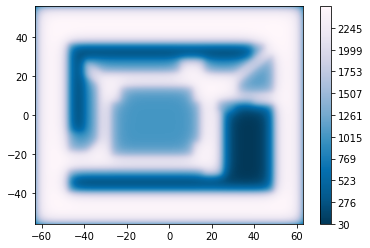

In [9]:
# Defines a Plot to show the smoothing of the supplied map to represent the respective potentials of the ground, the larger
# the potentials, the more attractive the ground is to the walker

cs = plt.contourf(X, Y, TrailPotential, levels=np.linspace(TrailPotential.min(),TrailPotential.max(),1000),cmap='PuBu_r')
cbar = plt.colorbar()

#plt.scatter(track[0:1999,0],track[0:1999,1])
plt.show()


In [10]:
#set up walker
def set_up_walker(route_id):
    global vel,pos,track,intens,dest,start,route
    #start
    start=np.array(route[route_id,0,:])
    #dest=(random.choice(ends))
    dest=np.array(route[route_id,1,:])
    vel=np.array([0.,0.])
    pos=np.array(start)
    #print (pos)
    track=np.zeros((2000,2))
#    track[0,:]=pos[:]
#



In [11]:

#Calculate gradients eq 19
#Trail gradient
def setup_potentials():
    global grad,desdirx,desdiry,dest
    grad=0.003*np.array(np.gradient(TrailPotential))
    #grad=0.002*np.array(np.gradient(TrailPotential)) ORIGINAL
    
    #print (dest)
#Destination potential
    DestinationPotential=-np.sqrt((dest[0]-x[:,None])**2+(dest[1]-y[None,:])**2)
#Combine gradients
    grad+=np.array(np.gradient(DestinationPotential)[:])
#Normalise
#grad[:,:,:]/=(np.sqrt(grad[0,:,:]**2+grad[1,:,:]**2))
    desdirx=ReBiSpline(x,y,grad[0,:,:],s=2)
    desdiry=ReBiSpline(x,y,grad[1,:,:],s=2)
    #plot()
    #print(grad)

NameError: name 'track' is not defined

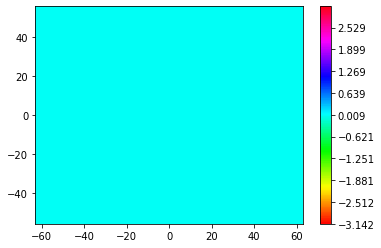

In [12]:
#Plot the direction
scgrad=np.arctan2(grad[1],grad[0])
levels = np.linspace(-np.pi, np.pi, 360)
cs = plt.contourf(X, Y,scgrad, levels=levels,cmap='hsv')

cbar = plt.colorbar()
plt.scatter(track[0:1999,0],track[0:1999,1])
#plt.scatter(start, dest)
print(start)
print(dest)
plt.show()



In [13]:
def calc_path():
    global pos,vel,intens,track,dest,dvel,tau
    
    i=0
    hist=10
    samp=10
    avpos=np.zeros((2,hist))
    #Setup While loop to run until either the walker reaches the destination or the walker has passed 2000 movement cycles to 
    #attempt to get there
    while (np.dot(pos-dest,pos-dest)>precision and i<2000):
    #set the postiion of the walker on its first then subsequent cycles
        
        #conditional logic saying to update the average position of the walker every 10 iterations
        #if (i%samp==0): avpos[:,(i%hist)//samp]=pos[:] #ORIGINAL
        if (i%samp==0): avpos[:,(i%(hist*samp))//samp]=pos[:]
            
        #print((i%hist)//samp)
        #print(avpos)
        
        gradmagnitude=max(0.0001,np.sqrt(desdirx(pos[0],pos[1])**2+desdiry(pos[0],pos[1])**2))
        xi=np.array(np.random.normal(0,1,2))
        vel[0]+= -1/tau*vel[0] + (1/tau) * desdirx(pos[0],pos[1])/gradmagnitude+np.sqrt(2.*eps/tau)*xi[0]
        vel[1]+= -1/tau*vel[1] + (1/tau) * desdiry(pos[0],pos[1])/gradmagnitude+np.sqrt(2.*eps/tau)*xi[1]
        
        pos+=dt*vel
        
        #vel[0]+=-1/tau*vel[0] + (dvel/tau)*desdirx(pos[0],pos[1])/gradmagnitude+np.sqrt(2.*eps/tau)*xi[0]
        #vel[1]+=-1/tau*vel[1] + (dvel/tau)*desdiry(pos[0],pos[1])/gradmagnitude+np.sqrt(2.*eps/tau)*xi[1]
        
        #Set the current position of the walker into the trakc array for the current iteration
        track[i,:]=pos[:]
        intens[int((pos[0]-xmin)*(Nx-1)/(xmax-xmin)),int((pos[1]-ymin)*(Ny-1)/(ymax-ymin))]+=1.
        i+=1
        if (i%(hist*samp)==0):
            meanpos=np.mean(avpos,axis=1)
            if (np.dot(pos-meanpos,pos-meanpos)<precision): 
                print ("Stalled progress ",pos,meanpos,vel, dest)
                break
    if (i==2000): print ("Missed goal ",dest,pos)           
    return i    
#stopping condition    



In [14]:
# Calculate Q_alpha (strength of markings) eq 15
def update_ground():
    global q_alpha,intens,z,g_max,t_track,g_nat
    q_alpha=intens*(1.-z/g_max)
# Time evolution of ground potential
    #zdiff=(1./t_track)*(g_nat-z)+q_alpha
    z+=(1./t_track)*(g_nat-z)+q_alpha
    #cs = plt.contourf(X, Y, zdiff, cmap=cm.PuBu_r)
    #cbar = plt.colorbar()
    #plt.show
    #z[140:160,45:75]



In [15]:
def plot_path():
    plt.contourf(X, Y, z, levels=np.linspace(z.min(),z.max(),1000),cmap='PuBu_r')
    plt.colorbar()
    #plt.scatter(track[0:1999,0],track[0:1999,1],1)
    plt.show(block=False)
    



In [16]:
tau = 5.


In [18]:
for i in range(0,10):
    calc_tr_new()
    intens[:]=0.
    for j in range(0,10):
        set_up_walker(np.random.randint(0,len(route)))
        setup_potentials()
        #calc_path()
        print(i, start," -> ", dest, pos, calc_path())
    update_ground()
    #plot_path()



0 [-24.  10.]  ->  [24.   -9.75] [23.05892635 -9.5750384 ] 508
0 [-24.  10.]  ->  [-2.75 14.  ] [-2.7303976  14.91674531] 255
0 [-24.  10.]  ->  [24.   2.5] [23.06358998  2.4110843 ] 485
0 [24.   2.5]  ->  [-24.     9.75] [-23.2933635   10.36011158] 483
0 [-2.5 14. ]  ->  [-24.     9.75] [-24.54402631  10.53587612] 256
0 [-2.5 14. ]  ->  [-24.     9.75] [-24.70413759  10.44818918] 254
0 [-24.  10.]  ->  [-2.75 14.  ] [-2.74819369 14.96788232] 248
0 [-24.  10.]  ->  [-2.75 14.  ] [-2.683971   14.93812481] 235
0 [24.   2.5]  ->  [-2.75 14.  ] [-2.48088147 14.9392114 ] 323
0 [-24.  10.]  ->  [24.   2.5] [23.05149064  2.42635407] 486
1 [24.   2.5]  ->  [-2.75 14.  ] [-2.80704309 14.94028348] 329
1 [24.   -9.75]  ->  [-24.     9.75] [-23.20402569   9.16706902] 494
1 [24.   -9.75]  ->  [-2.75 14.  ] [-2.71282749 14.97461474] 413
1 [-24.  10.]  ->  [-2.75 14.  ] [-2.78469065 14.9081316 ] 227
1 [24.   2.5]  ->  [-2.75 14.  ] [-2.51556359 14.95659196] 340
1 [24.   2.5]  ->  [-24.     9.75] [-23

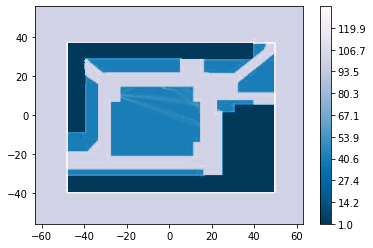

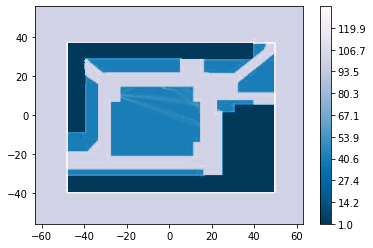

ValueError: stmt is neither a string nor callable

In [21]:
plot_path()



In [19]:
for i in range(0,Nx):
    for j in range(0,Ny):
        if (np.isnan(z[i,j])):
            print (i,j,g_max[i,j],Base[i,j,0])
        


In [20]:
def detect_local_maxima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_max = (filters.maximum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_maxima = local_max ^ eroded_background
    return np.where(detected_maxima) 

In [21]:
def plot_potentials():
    global dest
    TotPot = np.zeros((Nx,Ny))
    TotPot =- np.sqrt((dest[0]-x[:,None])**2+(dest[1]-y[None,:])**2)
    TotPot += 0.003*TrailPotential
    maxima=detect_local_maxima(TotPot)
    cs = plt.contourf(X, Y, TotPot, levels=np.linspace(TotPot.min(),TotPot.max(),1000),cmap='PuBu_r')
    cbar = plt.colorbar()
    print(maxima)
    plt.scatter(x[maxima[0]],y[maxima[1]])
    plt.show

(array([ 57, 156, 156, 156], dtype=int64), array([262,  61, 262, 375], dtype=int64))


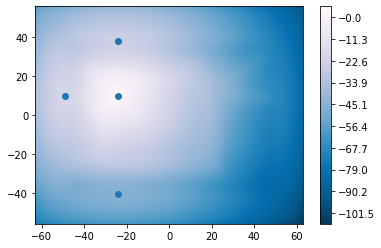

In [22]:
plot_potentials()

[24.   -9.75]
[-24.     9.75]


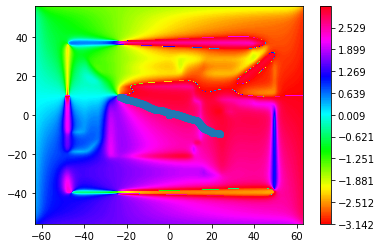

In [23]:
#Plot the direction
scgrad=np.arctan2(grad[1],grad[0])
levels = np.linspace(-np.pi, np.pi, 360)
cs = plt.contourf(X, Y,scgrad, levels=levels,cmap='hsv')

cbar = plt.colorbar()
plt.scatter(track[0:1999,0],track[0:1999,1])
#plt.scatter(start, dest)
print(start)
print(dest)
plt.show()



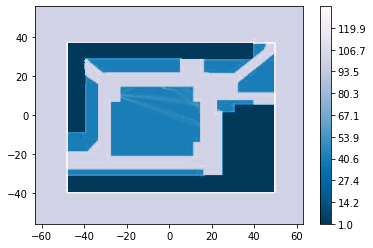

In [20]:
plot_path()

In [25]:
#Integrate z, trapezoid rule eq 20
# def calc_tr():
#    global xi,yi,TrailPotential,expdist,z,Weight,Nx,Ny
#    for xi in range(0,Nx): 
#        for yi in range(0,Ny):
#            TrailPotential[xi,yi]=np.sum(expdist[Nx-1-xi:2*Nx-1-xi,Ny-1-yi:2*Ny-1-yi]*z[:,:]*Weight[:,:])